In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras



2026-02-15 00:47:01.237257: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771116421.432782      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771116421.490591      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771116421.967067      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771116421.967104      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771116421.967107      24 computation_placer.cc:177] computation placer alr

In [2]:
train_dir = "../input/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/train"
test_dir = "../input/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/test"
val_dir = "../input/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray/val"
pneumonia = 'PNEUMONIA'
normal = 'NORMAL'


num_pneumonia = len(os.listdir(os.path.join(train_dir, pneumonia)))
num_normal = len(os.listdir(os.path.join(train_dir, normal)))
print(num_pneumonia, num_normal)


3875 1341


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

In [4]:
train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(224, 224))

validation = image_generator.flow_from_directory(val_dir, 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='binary',
                                                target_size=(224, 224))

test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='binary',
                                            target_size=(224, 224))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
total = num_normal + num_pneumonia

# Standard formula: total / (2 * count)
# This makes the "Normal" weight higher and "Pneumonia" weight lower
weight_for_0 = total / (2 * num_normal)      # Weight for Normal
weight_for_1 = total / (2 * num_pneumonia)   # Weight for Pneumonia

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for Normal (0): {weight_for_0:.2f}")      # Should be around 1.94
print(f"Weight for Pneumonia (1): {weight_for_1:.2f}")   # Should be around 0.67

Weight for Normal (0): 1.94
Weight for Pneumonia (1): 0.67


In [6]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

base_model = DenseNet121(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')



I0000 00:00:1771116439.988840      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1771116439.994826      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
layers = base_model.layers
print(f"The model has {len(layers)} layers")

The model has 428 layers


In [8]:
print(f"The input shape {base_model.input}")
print(f"The output shape {base_model.output}")

The input shape <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor>
The output shape <KerasTensor shape=(None, 1024), dtype=float32, sparse=False, ragged=False, name=keras_tensor_427>


**Adding Dropout**

In [9]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)

x = Dropout(0.5)(x)

predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=1e-4), 
              metrics=['accuracy'])

**This time we also use Early Stopping and Checkpoint**

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,   # Shrink LR by 5x when stuck
    patience=2,   # Be aggressive
    min_lr=1e-7,
    verbose=1
)
# 1. Early Stopping: Stop if validation accuracy doesn't improve for 3 epochs
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    patience=5, 
    restore_best_weights=True,
    verbose=1
)

# 2. Model Checkpoint: Save only the version with the highest validation accuracy
checkpoint = ModelCheckpoint(
    'densenet_90plus.h5', 
    monitor='val_accuracy', 
    save_best_only=True, 
    mode='max',
    verbose=1
)


In [11]:
r = model.fit(
    train,
    epochs=20,
    validation_data=validation,
    class_weight=class_weight,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1771116501.698501      88 service.cc:152] XLA service 0x7ae0b00024f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771116501.698550      88 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1771116501.698556      88 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1771116512.255062      88 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1771116633.341699      88 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


652/652 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.8371 - loss: 0.3043
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to densenet_90plus.h5


652/652 ━━━━━━━━━━━━━━━━━━━━ 330s 220ms/step - accuracy: 0.8372 - loss: 0.3041 - val_accuracy: 1.0000 - val_loss: 0.1436 - learning_rate: 1.0000e-04
Epoch 2/20
652/652 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9589 - loss: 0.1137
Epoch 2: val_accuracy did not improve from 1.00000
652/652 ━━━━━━━━━━━━━━━━━━━━ 103s 157ms/step - accuracy: 0.9589 - loss: 0.1137 - val_accuracy: 1.0000 - val_loss: 0.0506 - learning_rate: 1.0000e-04
Epoch 3/20
652/652 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9731 - loss: 0.0746
Epoch 3: val_accuracy did not improve from 1.00000
652/652 ━━━━━━━━━━━━━━━━━━━━ 102s 157ms/step - accuracy: 0.9731 - loss: 0.0746 - val_accuracy: 0.9375 - val_loss: 0.1367 - learning_rate: 1.0000e-04
Epoch 4/20
652/652 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9791 - loss: 0.0630
Epoch 4: val_accuracy did not improve from 1.00000

Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
652/652 ━━━━━━━━━━━━━━━━━━━━ 102s 157ms/step - accuracy: 0

Text(0.5, 1.0, 'Accuracy Evolution')

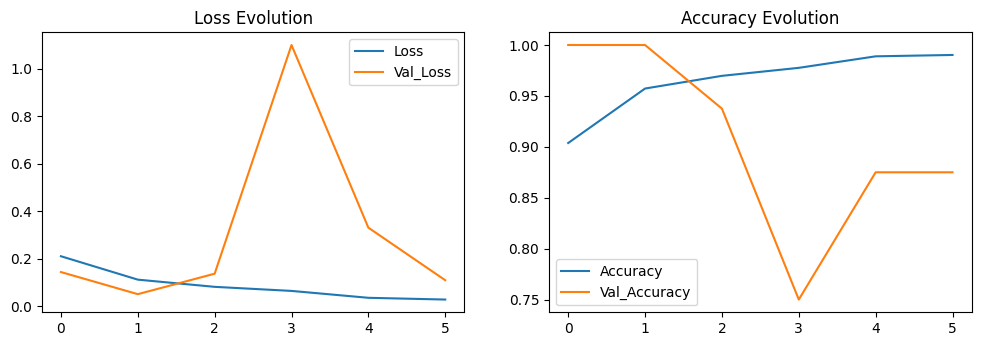

In [12]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [13]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.7134 - loss: 0.8544
Test Accuracy: 84.78%
652/652 ━━━━━━━━━━━━━━━━━━━━ 105s 149ms/step - accuracy: 0.9835 - loss: 0.0471
Train Accuracy: 98.10%


In [14]:
predicted_vals = model.predict(test, steps=len(test))

624/624 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step


In [15]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(test.classes, predicted_vals > 0.5))
pd.DataFrame(classification_report(test.classes, predicted_vals > 0.5, output_dict=True))

[[134 100]
 [  2 388]]


,0,1,accuracy,macro avg,weighted avg
precision,0.985294,0.795082,0.836538,0.890188,0.866412
recall,0.572650,0.994872,0.836538,0.783761,0.836538
f1-score,0.724324,0.883827,0.836538,0.804076,0.824013
support,234.000000,390.000000,0.836538,624.000000,624.000000


In [16]:
model.save('densenet_trained.h5') 

print("Model saved successfully to /kaggle/working/densenet_trained.h5")

Model saved successfully to /kaggle/working/densenet_trained.h5
